In [203]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [153]:
def passes_adfuller_test(residuals, alpha):
    p_value = adfuller(residuals)[1]
    if p_value < alpha:
        return True
    return False

def get_regression_model(stock1, stock2):
    '''
     Function to regress both stock series with each and retrieve the fitted model.

     Regression Function:
        Stock2 -> F (Stock1)
    '''
    
    X = sm.add_constant(stock1) 
    model = sm.OLS(stock2, X).fit()
    return model

In [154]:
# Loading the training data (2017 to 2022)

DATA = pd.read_csv('./data/closing_prices.csv').set_index('Date')

In [155]:
# Get the list of stock tickers
TICKERS = DATA.columns.tolist()
TICKERS

['ADANIENT',
 'ADANIPORTS',
 'APOLLOHOSP',
 'ASIANPAINT',
 'AXISBANK',
 'BAJAJ-AUTO',
 'BAJFINANCE',
 'BAJAJFINSV',
 'BEL',
 'BPCL',
 'BHARTIARTL',
 'BRITANNIA',
 'CIPLA',
 'COALINDIA',
 'DRREDDY',
 'EICHERMOT',
 'GRASIM',
 'HCLTECH',
 'HDFCBANK',
 'HEROMOTOCO',
 'HINDALCO',
 'HINDUNILVR',
 'ICICIBANK',
 'INDUSINDBK',
 'INFY',
 'JSWSTEEL',
 'KOTAKBANK',
 'LT',
 'M&M',
 'MARUTI',
 'NTPC',
 'NESTLEIND',
 'ONGC',
 'POWERGRID',
 'RELIANCE',
 'SHRIRAMFIN',
 'SBIN',
 'SUNPHARMA',
 'TCS',
 'TATACONSUM',
 'TATAMOTORS',
 'TATASTEEL',
 'TECHM',
 'TITAN',
 'TRENT',
 'ULTRACEMCO',
 'WIPRO']

In [156]:
# Split training data (2017 to 2022) from the corpus

TRAINING_DATA = DATA[:'2023-01-01']
TESTING_DATA = DATA['2023-01-01':]


In [157]:
PAIRS = []

for first_ticker in range(len(TICKERS) - 1):
    for second_ticker in range(first_ticker + 1, len(TICKERS)):

        ticker1 = TICKERS[first_ticker]
        ticker2 = TICKERS[second_ticker]

        data1 = TRAINING_DATA[ticker1]
        data2 = TRAINING_DATA[ticker2]

        # Retrieve model 
        model = get_regression_model(data1, data2)

        # Get residuals to test for stationarity
        residuals = model.resid

        # Gauge cointegration by performing the AdFuller test with a confidence level of 99%
        if passes_adfuller_test(residuals, alpha=0.01):
            print (f'Pair ({ticker1}, {ticker2}) is cointegrated (99% confidence)')
            PAIRS.append({
                'pair': str((ticker1, ticker2)),
                'ticker1': ticker1,
                'ticker2': ticker2,
                'model': model
            })


Pair (ADANIPORTS, APOLLOHOSP) is cointegrated (99% confidence)
Pair (ADANIPORTS, BAJAJ-AUTO) is cointegrated (99% confidence)
Pair (ADANIPORTS, CIPLA) is cointegrated (99% confidence)
Pair (ADANIPORTS, JSWSTEEL) is cointegrated (99% confidence)
Pair (ADANIPORTS, ULTRACEMCO) is cointegrated (99% confidence)
Pair (APOLLOHOSP, ASIANPAINT) is cointegrated (99% confidence)
Pair (APOLLOHOSP, BAJAJFINSV) is cointegrated (99% confidence)
Pair (APOLLOHOSP, HCLTECH) is cointegrated (99% confidence)
Pair (APOLLOHOSP, HDFCBANK) is cointegrated (99% confidence)
Pair (APOLLOHOSP, INFY) is cointegrated (99% confidence)
Pair (APOLLOHOSP, TITAN) is cointegrated (99% confidence)
Pair (APOLLOHOSP, ULTRACEMCO) is cointegrated (99% confidence)
Pair (ASIANPAINT, BAJFINANCE) is cointegrated (99% confidence)
Pair (ASIANPAINT, HCLTECH) is cointegrated (99% confidence)
Pair (ASIANPAINT, HDFCBANK) is cointegrated (99% confidence)
Pair (ASIANPAINT, INFY) is cointegrated (99% confidence)
Pair (ASIANPAINT, KOTAKBAN

In [170]:
class PairsBacktester:

    def __init__(self, ticker1, ticker2, model):
        self.ticker1 = ticker1
        self.ticker2 = ticker2 
        self.model = model

        self.residuals = model.resid
        self.residuals_mean = self.residuals.mean()
        self.residuals_std = self.residuals.std()

        self.res_overval_cutoff = self.residuals_mean + self.residuals_std
        self.res_underval_cutoff = self.residuals_mean - self.residuals_std

        self.data1 = TESTING_DATA[[ticker1]].squeeze()
        self.data2 = TESTING_DATA[[ticker2]].squeeze()
        self.testing_data = pd.merge(
            left=self.data1,
            left_index=True,
            right=self.data2,
            right_index=True
        )


        X_new = sm.add_constant(self.data1)
        Y_preds = self.model.predict(X_new)
        Y_actual = self.data2
        test_residuals = Y_actual - Y_preds


        # print (test_residuals)
        test_residuals = pd.DataFrame({
            'date': test_residuals.index,
            'residual': test_residuals.values
        })
        
        self.testing_data = pd.merge(
            left=self.testing_data,
            left_index=True,
            right=test_residuals,
            right_on='date'
        )


        self.testing_data['signal'] = 'None'

        self.trades = []

        # Temp variables to store trade data
        self.current_trade = {}

        # Denotes if an overvalued residual trade is active (curr_residual > residual_mean + residual_std)
        self.in_overval_trade = False

        # Denotes if an undervalued residual trade is active (curr_residual < residual_mean - residual_std)
        self.in_underval_trade = False

    def exit_trade(self):
        self.trades.append(self.current_trade)
        self.current_trade = {}
    
    def set_exit_info(self, exit_date, short_exit_price, long_exit_price):
        self.current_trade['exit_date'] = exit_date
        self.current_trade['short_exit_price'] = short_exit_price
        self.current_trade['long_exit_price'] = long_exit_price
    
    def set_entry_info(self, pair, residual_state, entry_date, short_ticker, long_ticker, short_entry_price, long_entry_price):
        self.current_trade['pair'] = pair
        self.current_trade['residual_state'] = residual_state
        self.current_trade['entry_date'] = entry_date
        self.current_trade['short_ticker'] = short_ticker
        self.current_trade['long_ticker'] = long_ticker
        self.current_trade['short_entry_price'] = short_entry_price
        self.current_trade['long_entry_price'] = long_entry_price
    
    def calculate_trade_statistics(self, equal_wts=True):
        if len(self.trades) == 0:
            return

        self.trades['short_net_perc'] = (self.trades['short_entry_price'] - self.trades['short_exit_price']) / self.trades['short_entry_price']
        self.trades['long_net_perc'] = (self.trades['long_exit_price'] - self.trades['long_entry_price']) / self.trades['long_entry_price']

        self.trades['entry_date'] = pd.to_datetime(self.trades['entry_date'])
        self.trades['exit_date'] = pd.to_datetime(self.trades['exit_date'])
        self.trades['duration'] = (self.trades['exit_date'] - self.trades['entry_date']).apply(lambda x: pd.Timedelta(x).days)
        

        if equal_wts:
            self.ticker1_wt, self.ticker2_wt = 0.5, 0.5
        else:
            self.ticker1_wt = self.model.params[f'{self.ticker1}'] / (1 + self.model.params[f'{self.ticker1}'])
            self.ticker2_wt = 1 / (1 + self.model.params[f'{self.ticker1}'])

        self.trades['net_perc'] = self.trades.apply(
            lambda row: (row['short_net_perc']*self.ticker2_wt + row['long_net_perc']*self.ticker1_wt) if row['short_ticker'] == self.ticker2 else \
            (row['short_net_perc']*self.ticker1_wt + row['long_net_perc']*self.ticker2_wt), axis=1
        )
    
    def trade(self):
        for index, row in self.testing_data.iterrows():
            if self.in_overval_trade:
                # Exit trade overval trade
                if row['residual'] < self.residuals_mean:

                    self.testing_data.loc[index, 'signal'] = 'exit overval'
                    self.in_overval_trade = False

                    self.set_exit_info(
                        exit_date=row['date'],
                        short_exit_price=row[f'{self.ticker2}'],
                        long_exit_price=row[f'{self.ticker1}']
                    )

                    self.exit_trade()

            elif self.in_underval_trade:
                # Exit trade underval trade
                if row['residual'] > self.residuals_mean:

                    self.testing_data.loc[index, 'signal'] = 'exit underval'
                    self.in_underval_trade = False
                    

                    self.set_exit_info(
                        exit_date=row['date'],
                        short_exit_price=row[f'{self.ticker1}'],
                        long_exit_price=row[f'{self.ticker2}']
                    )

                    self.exit_trade()

            else:

                if row['residual'] > self.res_overval_cutoff:

                    self.testing_data.loc[index, 'signal'] = 'enter overval'
                    self.in_overval_trade = True

                    self.set_entry_info(
                        pair=(self.ticker1, self.ticker2),
                        residual_state='overval',
                        entry_date=row['date'],
                        short_ticker=self.ticker2,
                        long_ticker=self.ticker1,
                        short_entry_price=row[f'{self.ticker2}'],
                        long_entry_price=row[f'{self.ticker1}']
                    )


                elif row['residual'] < self.res_underval_cutoff:
                    self.testing_data.loc[index, 'signal'] = 'enter underval'
                    self.in_underval_trade = True

                    self.set_entry_info(
                        pair=(self.ticker1, self.ticker2),
                        residual_state='underval',
                        entry_date=row['date'],
                        short_ticker=self.ticker1,
                        long_ticker=self.ticker2,
                        short_entry_price=row[f'{self.ticker1}'],
                        long_entry_price=row[f'{self.ticker2}']
                    )
                else:
                    self.testing_data.loc[index, 'signal'] = 'none'

        self.trades = pd.DataFrame(self.trades)
        self.calculate_trade_statistics()      

In [179]:
ALL_TRADES = pd.DataFrame()

PAIRWISE_BACKTESTING_CLASS = {}

for pair in PAIRS:
    pair_bb = PairsBacktester(
        pair['ticker1'],
        pair['ticker2'],
        pair['model']
    )
    pair_bb.trade()
    pair_bb.calculate_trade_statistics(equal_wts=True)
    PAIRWISE_BACKTESTING_CLASS[f'{str((pair["ticker1"], pair["ticker2"]))}'] = pair_bb
    ALL_TRADES = pd.concat([ALL_TRADES, pair_bb.trades])


In [220]:
ALL_TRADES[ALL_TRADES['pair'] == ('GRASIM', 'HINDALCO')]

,pair,residual_state,entry_date,short_ticker,long_ticker,short_entry_price,long_entry_price,exit_date,short_exit_price,long_exit_price,short_net_perc,long_net_perc,duration,net_perc
0,"(GRASIM, HINDALCO)",overval,2023-01-11,HINDALCO,GRASIM,490.950012,1628.574463,2023-02-10,433.149994,1628.823486,0.117731,0.000153,30,0.058942
1,"(GRASIM, HINDALCO)",underval,2023-03-27,GRASIM,HINDALCO,1624.490723,389.950012,2023-12-22,2038.096069,570.450012,-0.254606,0.462880,270,0.104137


In [168]:
results = ALL_TRADES.groupby('pair').agg(
    count_total_trades=('residual_state', 'count'),
    count_overval_trades=('residual_state', lambda x: (x == 'overval').sum()),  # Count occurrences of 'overval'
    count_underval_trades=('residual_state', lambda x: (x == 'underval').sum()),  # Count occurrences of 'underval'
    mean_duration_days=('duration', 'mean'),  # Mean duration
    mean_net_perc=('net_perc', 'mean')  # Mean net_perc
)

In [169]:
results.sort_values(by='mean_net_perc', ascending=False)

,count_total_trades,count_overval_trades,count_underval_trades,mean_duration_days,mean_net_perc
pair,,,,,
"(ADANIPORTS, APOLLOHOSP)",1,1,0,312.000000,0.191164
"(BAJFINANCE, HCLTECH)",1,1,0,176.000000,0.098080
"(APOLLOHOSP, HDFCBANK)",1,1,0,133.000000,0.095972
"(BAJFINANCE, INFY)",1,1,0,90.000000,0.089365
"(ADANIPORTS, BAJAJ-AUTO)",1,0,1,23.000000,0.086438
"(ADANIPORTS, JSWSTEEL)",1,1,0,337.000000,0.086092
"(GRASIM, HINDALCO)",2,1,1,150.000000,0.081539
"(HCLTECH, HDFCBANK)",1,1,0,232.000000,0.081489
"(ADANIPORTS, CIPLA)",3,3,0,91.666667,0.080488


In [215]:
best_pair = ('GRASIM', 'HINDALCO')
testing_data_best_pair = PAIRWISE_BACKTESTING_CLASS[str(best_pair)]

In [222]:
testing_data_best_pair.testing_data['signal'].value_counts()

signal
None              201
none               40
enter overval       1
exit overval        1
enter underval      1
exit underval       1
Name: count, dtype: int64

In [ ]:
testing_data_best_pair

In [196]:
def plot(t, ticker1, ticker2, res_mean, res_std, overval_cutoff, underval_cutoff):
    # t = t.set_index('date')
    plt.figure(figsize=(30,10))
    plt.plot(t['residual'], label='Test Residuals', color='purple')
    plt.plot(t[f'{ticker1}'], label=ticker1, color='orange')
    plt.plot(t[f'{ticker2}'], label=ticker2, color='blue')
    plt.axhline(res_mean, color='black', linestyle='--', lw=1)
    plt.axhline(overval_cutoff, color='black', linestyle='--', lw=1)
    plt.axhline(underval_cutoff, color='black', linestyle='--', lw=1)
    plt.xlabel('Date')
    plt.ylabel('Residuals')
    plt.legend()
    plt.grid(True)
    plt.show()

In [227]:
def plot(t, ticker1, ticker2, res_mean, res_std, overval_cutoff, underval_cutoff):
    # Ensure the date column is in datetime format
    t['date'] = pd.to_datetime(t['date'])

    # Create subplots
    fig, axs = plt.subplots(3, 1, figsize=(30, 10), sharex=True)

    # Plot for residuals
    axs[0].plot(t['date'], t['residual'], label='Test Residuals', color='purple')
    axs[0].axhline(res_mean, color='black', linestyle='--', lw=1, label='Mean Residual')
    axs[0].axhline(overval_cutoff, color='black', linestyle='--', lw=1, label='Overval Cutoff')
    axs[0].axhline(underval_cutoff, color='black', linestyle='--', lw=1, label='Underval Cutoff')
    axs[0].set_ylabel('Residuals')
    axs[0].legend()
    axs[0].set_title('Residuals Plot')

    # Plot for ticker1
    axs[1].plot(t['date'], t[ticker1], label=ticker1, color='orange')
    axs[1].set_ylabel(f'{ticker1} Price')
    axs[1].legend()
    axs[1].set_title(f'{ticker1} Price Plot')

    # Plot for ticker2
    axs[2].plot(t['date'], t[ticker2], label=ticker2, color='blue')
    axs[2].set_ylabel(f'{ticker2} Price')
    axs[2].legend()
    axs[2].set_title(f'{ticker2} Price Plot')

    # Set common X label
    axs[2].set_xlabel('Date')

    for index, row in t.iterrows():
        date = row['date']
        signal = row['signal']
        
        # Add annotations based on the signal conditions
        if signal == 'enter overval':
            axs[2].annotate('Sell', xy=(date, row[ticker2]), xytext=(date, row[ticker2] + 50),
                            arrowprops=dict(facecolor='red', shrink=0.05), fontsize=10, color='red')
            axs[1].annotate('Buy', xy=(date, row[ticker1]), xytext=(date, row[ticker1] + 50),
                            arrowprops=dict(facecolor='green', shrink=0.05), fontsize=10, color='green')
        elif signal == 'exit overval':
            axs[1].annotate('Sell', xy=(date, row[ticker1]), xytext=(date, row[ticker1] + 50),
                            arrowprops=dict(facecolor='red', shrink=0.05), fontsize=10, color='red')
            axs[2].annotate('Buy', xy=(date, row[ticker2]), xytext=(date, row[ticker2] + 50),
                            arrowprops=dict(facecolor='green', shrink=0.05), fontsize=10, color='green')
        elif signal == 'enter underval':
            axs[1].annotate('Sell', xy=(date, row[ticker1]), xytext=(date, row[ticker1] + 50),
                            arrowprops=dict(facecolor='red', shrink=0.05), fontsize=10, color='red')
            axs[2].annotate('Buy', xy=(date, row[ticker2]), xytext=(date, row[ticker2] + 50),
                            arrowprops=dict(facecolor='green', shrink=0.05), fontsize=10, color='green')
        elif signal == 'exit underval':
            axs[2].annotate('Sell', xy=(date, row[ticker2]), xytext=(date, row[ticker2] + 50),
                            arrowprops=dict(facecolor='red', shrink=0.05), fontsize=10, color='red')
            axs[1].annotate('Buy', xy=(date, row[ticker1]), xytext=(date, row[ticker1] + 50),
                            arrowprops=dict(facecolor='green', shrink=0.05), fontsize=10, color='green')



    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()


enter overval
exit overval
enter underval
exit underval


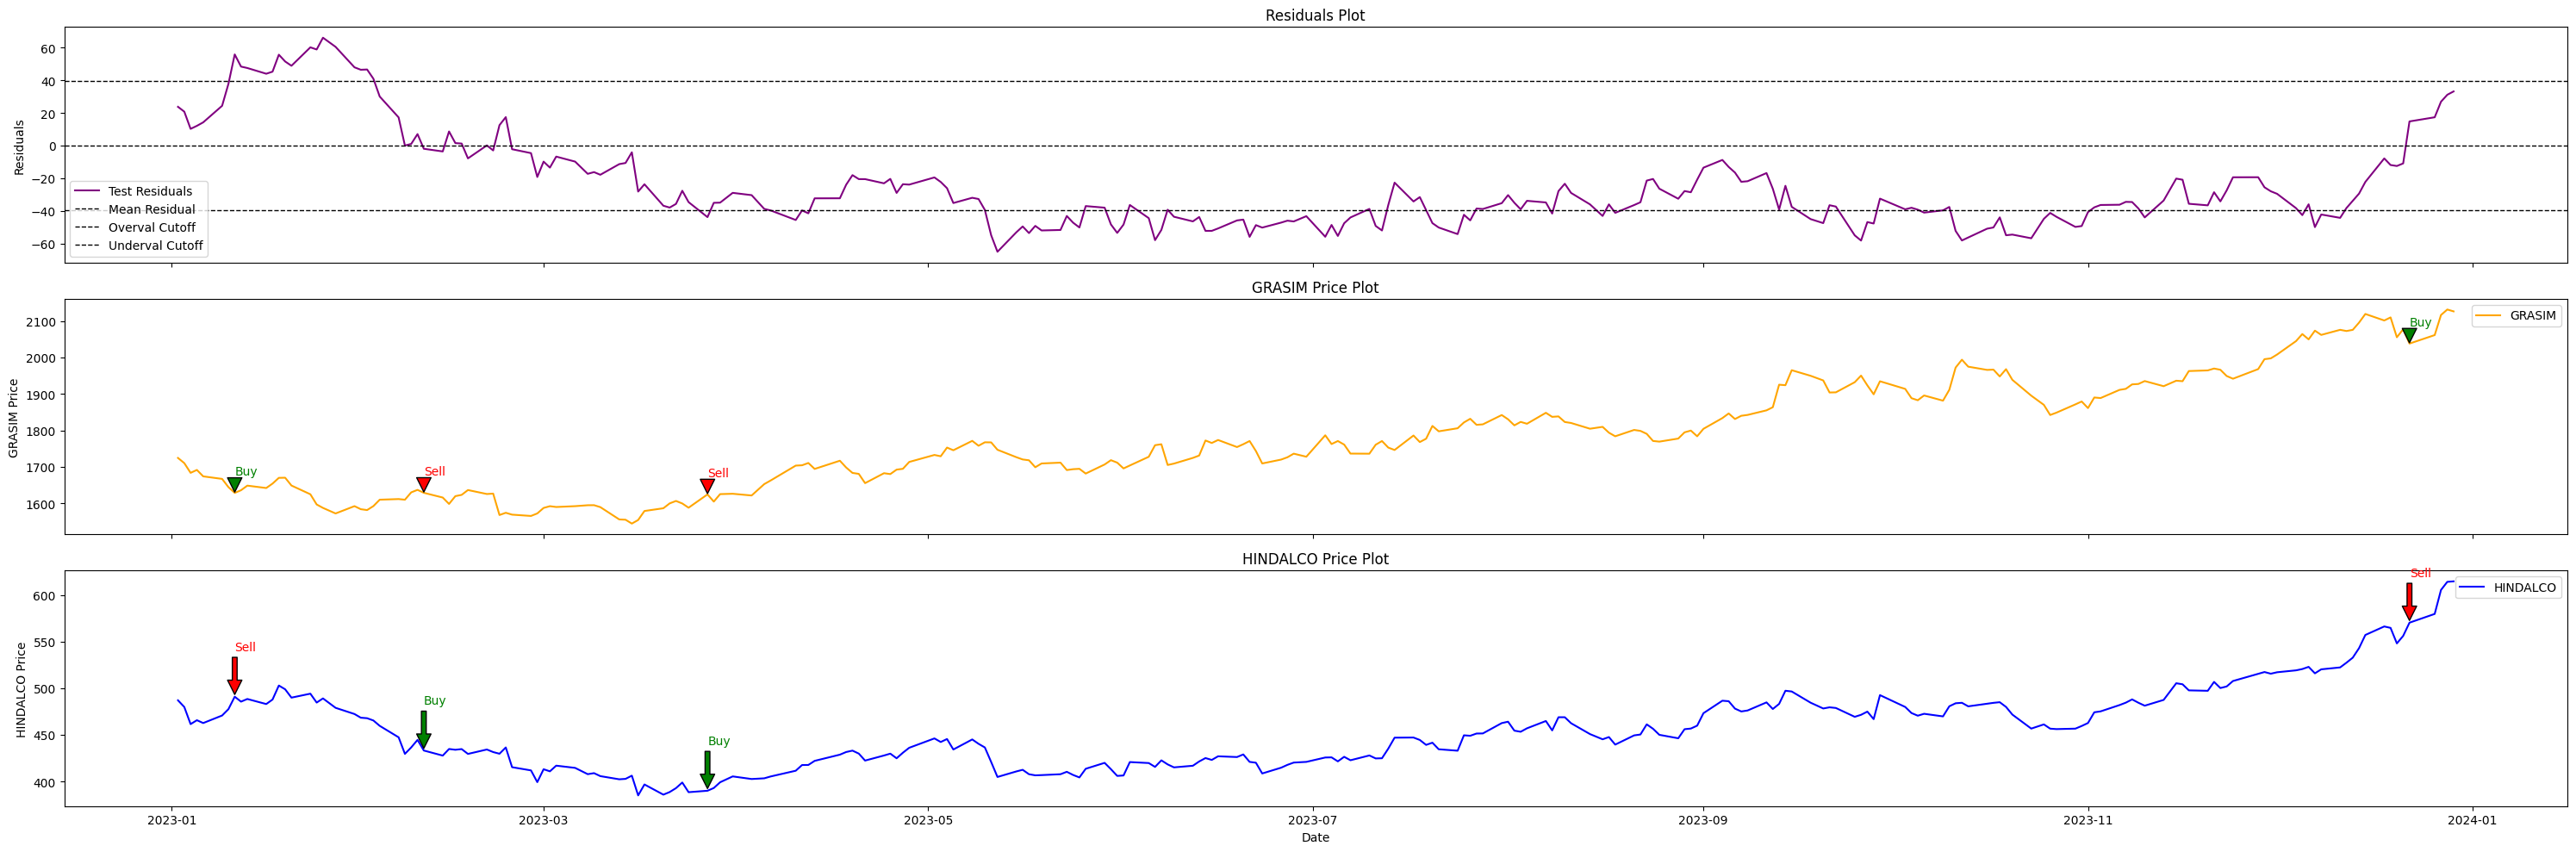

In [228]:
plot(
    t=testing_data_best_pair.testing_data,
    ticker1=testing_data_best_pair.ticker1,
    ticker2=testing_data_best_pair.ticker2,
    res_mean=testing_data_best_pair.residuals_mean,
    res_std=testing_data_best_pair.residuals_std,
    overval_cutoff=testing_data_best_pair.res_overval_cutoff,
    underval_cutoff=testing_data_best_pair.res_underval_cutoff
)